In [55]:
#!/usr/bin/env python

# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Xinlei Chen, based on code from Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
# %matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

from model.config import cfg
from model.test import im_detect
from torchvision.ops import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

import datetime

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


In [56]:
def transform_bird_eye_view(img):
    IMAGE_H = img.shape[0]
    IMAGE_W = img.shape[1]
    
    src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    dst = np.float32([[246, IMAGE_H], [IMAGE_W-246, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    plt.imshow(img) # Show results
    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results
    plt.show()

In [57]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    
    if len(inds) == 0:
        return

    display(class_name, inds)

    
    im = im[:, :, (2, 1, 0)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(24, 12))
#     fig.set_size_inches(np.shape(im)[0], np.shape(im)[1])
    ax[0].imshow(im, aspect='equal')
    ax[1].set(xlim=(0, np.shape(im)[1]), ylim=(np.shape(im)[0], 0), aspect='equal')
    fig.subplots_adjust(wspace=0.)
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
    
        display(bbox)
        
        ax[0].add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax[1].scatter(((bbox[0]+bbox[2])/2,), ((bbox[1]+bbox[3])/2, ), marker='d', s=20*4*5)
        ax[0].text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax[0].set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
#     plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [60]:
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time(), boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(torch.from_numpy(cls_boxes), torch.from_numpy(cls_scores), NMS_THRESH)
        dets = dets[keep.numpy(), :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

In [12]:
demonet = 'res101' # Network to use [vgg16 res101]
dataset = 'pascal_voc_0712' # Trained dataset [pascal_voc pascal_voc_0712]

def load_module():
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    # model path
    saved_model = os.path.join('../output', demonet,
                              NETS[demonet][0] %(70000 if dataset == 'pascal_voc' else 110000))


    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    # load network
    if demonet == 'vgg16':
        net = vgg16()
    elif demonet == 'res101':
        net = resnetv1(num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(21,
                          tag='default', anchor_scales=[8, 16, 32])

    net.load_state_dict(torch.load(saved_model, map_location=lambda storage, loc: storage))

    net.eval()
    if not torch.cuda.is_available():
        net._device = 'cpu'
    net.to(net._device)

    return net

In [7]:
NMS_THRESH = 0.3
CONF_THRESH = 0.8

def get_coords(net, image_name, categories, x_offset=0, y_offset=0):
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)
    
    scores, boxes = im_detect(net, im)
    
    result = dict()
    for category in categories:
        idx_boxes = boxes[:, 4*category:4*(category + 1)]
        idx_scores = scores[:, category]
        clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
        valid_idxs = np.squeeze(np.argwhere(idx_scores[clean_idx] > CONF_THRESH), axis=-1)
        valid_boxes = idx_boxes[valid_idxs]
        
        result[category] = np.vstack((
            (x_offset + (valid_boxes[:, 0] + valid_boxes[:, 2]) / 2),
            (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)).T
        
    return result

In [8]:
IMAGE_H = 512
IMAGE_W = 1392

src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H], [0, 0], [IMAGE_W, 0]])
dst = np.float32([[246, IMAGE_H], [IMAGE_W-246, IMAGE_H], [0, 0], [IMAGE_W, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

In [9]:
def transform_coords(coords):
    coord = np.pad(coord, ((0, 0), (0, 1)), mode="constant", constant_values=1)
    transformed = np.dot(M, coord)
    return transformed[:2] / transformed[-1]

In [21]:
target_classes = [7, 15]
display([CLASSES[tc] for tc in target_classes])

net = load_module()
left = get_coords(net, "0000000000_L.png",target_classes)
right = get_coords(net, "0000000000_R.png",target_classes, x_offset=666)

['car', 'person']

In [17]:
display(left, right)

{7: array([[173.78174, 387.0295 ]], dtype=float32),
 15: array([[129.80537 , 378.90228 ],
        [506.01068 , 259.93384 ],
        [506.9964  , 258.93777 ],
        [ 61.148193, 326.6969  ]], dtype=float32)}

{7: array([[893.88196, 298.69485]], dtype=float32),
 15: array([[ 893.50055,  303.69052],
        [ 736.82556,  262.1867 ],
        [1067.3945 ,  262.17065]], dtype=float32)}

In [25]:
output = dict()
for tc in target_classes:
    output[tc] = np.concatenate([d[tc] for d in (left, right)])
display(output)

{7: array([[173.78174, 387.0295 ],
        [893.88196, 298.69485]], dtype=float32),
 15: array([[ 129.80537 ,  378.90228 ],
        [ 506.01068 ,  259.93384 ],
        [ 506.9964  ,  258.93777 ],
        [  61.148193,  326.6969  ],
        [ 893.50055 ,  303.69052 ],
        [ 736.82556 ,  262.1867  ],
        [1067.3945  ,  262.17065 ]], dtype=float32)}

In [41]:
def show_image(left_im_name, right_im_name):
    im_left_file = os.path.join(cfg.DATA_DIR, 'demo', left_im_name)
    left_im = cv2.imread(im_left_file)
    im_right_file = os.path.join(cfg.DATA_DIR, 'demo', right_im_name)
    right_im = cv2.imread(im_right_file)

    fig, ax = plt.subplots(ncols=2, figsize=(24, 24))
    ax[0].imshow(left_im, aspect='equal')
    ax[1].imshow(right_im, aspect='equal')
    
#     plt.axis('off')
    plt.tight_layout()
    
    plt.draw()

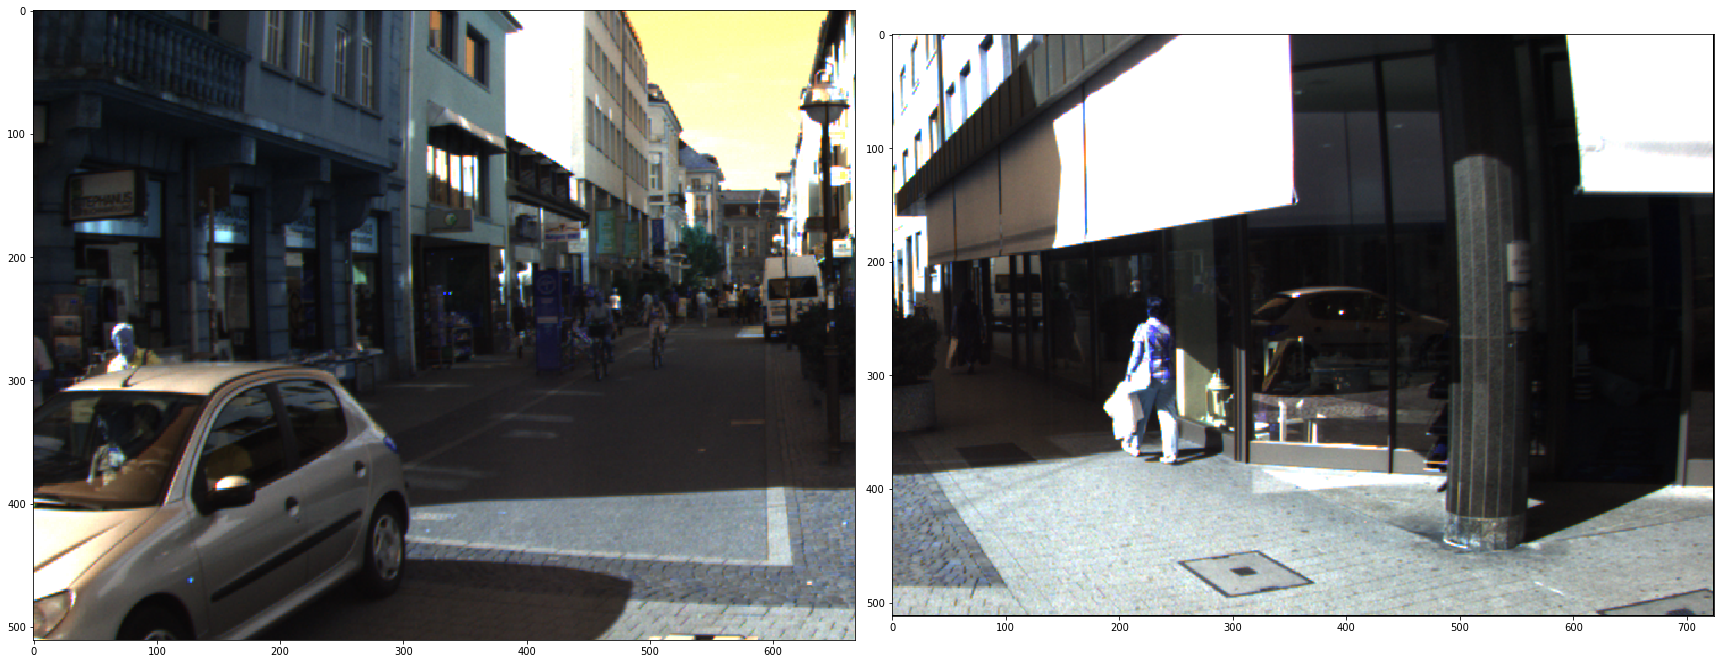

In [42]:
show_image("0000000000_L.png", "0000000000_R.png")

In [50]:
coords.T

NameError: name 'coords' is not defined

In [48]:
def draw_points(coords):
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.set(xlim=(0, IMAGE_W), ylim=(IMAGE_H, 0), aspect='equal')    
    
    ax.scatter(coords.T, marker='d', s=20*4*5)
    plt.draw()

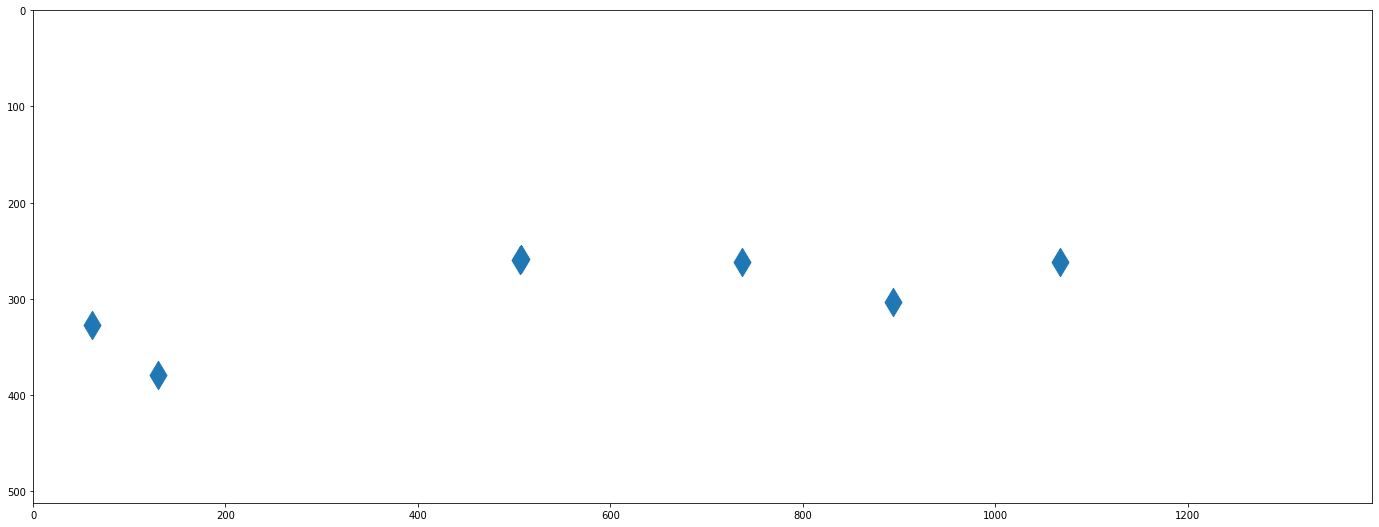

In [52]:
draw_points(output[15])

In [ ]:
nms(torch.from_numpy(cls_boxes), torch.from_numpy(cls_scores), NMS_THRESH)

In [ ]:
np.shape(scores[:, cls_ind][:, np.newaxis])

In [ ]:
# display(scores[:, cls_ind])
valid_idx = np.argwhere(scores[:, cls_ind] > 0.9)
display(valid_idx.squeeze())
display(boxes[:, 4*cls_ind:4*(cls_ind + 1)])

In [ ]:
array([173.78174, 387.0295 ], dtype=float32)

CLASSES[7]

In [ ]:
cls_ind = 7
idx_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
display(idx_boxes)
display(np.shape(idx_boxes))

idx_scores = scores[:, cls_ind]
display(np.shape(idx_scores))

NMS_THRESH = 0.3
clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
display(clean_idx)
display(idx_scores[clean_idx.numpy()])

valid_idxs = np.squeeze(np.argwhere(idx_scores[clean_idx] > 0.1), axis=-1)
display("valid_scores", valid_idxs, np.shape(valid_idxs))

valid_boxes = idx_boxes[valid_idxs]
display(valid_boxes)
display(np.shape(valid_boxes))

display(np.shape((valid_boxes[:, 0] + valid_boxes[:, 2]) / 2))

display((valid_boxes[:, 0] + valid_boxes[:, 2]) / 2, (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)
display(np.vstack(((valid_boxes[:, 0] + valid_boxes[:, 2]) / 2, (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)))
display(np.vstack(((valid_boxes[:, 0] + valid_boxes[:, 2]) / 2, (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)).T)

In [ ]:
display(boxes)
display(np.shape(boxes))
display(np.shape(scores))

In [ ]:
# Load the demo image
im_file = os.path.join(cfg.DATA_DIR, 'demo', '0000000000_L.png')
im = cv2.imread(im_file)

# Detect all object classes and regress object bounds
timer = Timer()
timer.tic()
scores, boxes = im_detect(net, im)

In [ ]:
print (boxes)

Loaded network ../output\res101\res101_faster_rcnn_iter_110000.pth
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/0000000000_L.png
Detection took 0.245s for 300 object proposals


1

2

3

4

5

6

'bus'

array([0], dtype=int64)

array([581.59656, 194.51393, 644.6881 , 278.11737], dtype=float32)

7

'car'

array([0], dtype=int64)

array([  0.     , 264.05902, 347.56348, 510.     ], dtype=float32)

8

9

10

11

12

13

14

15

'person'

array([0, 1, 2, 3], dtype=int64)

array([492.41104, 219.78981, 519.61035, 300.07788], dtype=float32)

array([442.31058, 225.30415, 476.27914, 305.0305 ], dtype=float32)

array([ 33.000175, 248.21349 , 106.27773 , 307.1319  ], dtype=float32)

array([ 39.417305, 327.0936  ,  84.49724 , 385.97586 ], dtype=float32)

16

17

18

19

20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/0000000000_R.png
Detection took 0.231s for 300 object proposals


1

2

3

4

5

6

7

'car'

array([0], dtype=int64)

array([293.88635, 217.73236, 510.72577, 313.63727], dtype=float32)

8

9

10

11

12

13

14

15

'person'

array([0, 1, 2], dtype=int64)

array([193.65887, 215.4292 , 261.3422 , 391.95184], dtype=float32)

array([ 54.655304, 220.63626 ,  86.99585 , 303.73715 ], dtype=float32)

array([137.84206, 211.94705, 163.95149, 299.681  ], dtype=float32)

16

17

18

19

20

2019-11-13 17:11:38.995465 [ 0:00:01.163889 ] 2019-11-13 17:11:40.159354


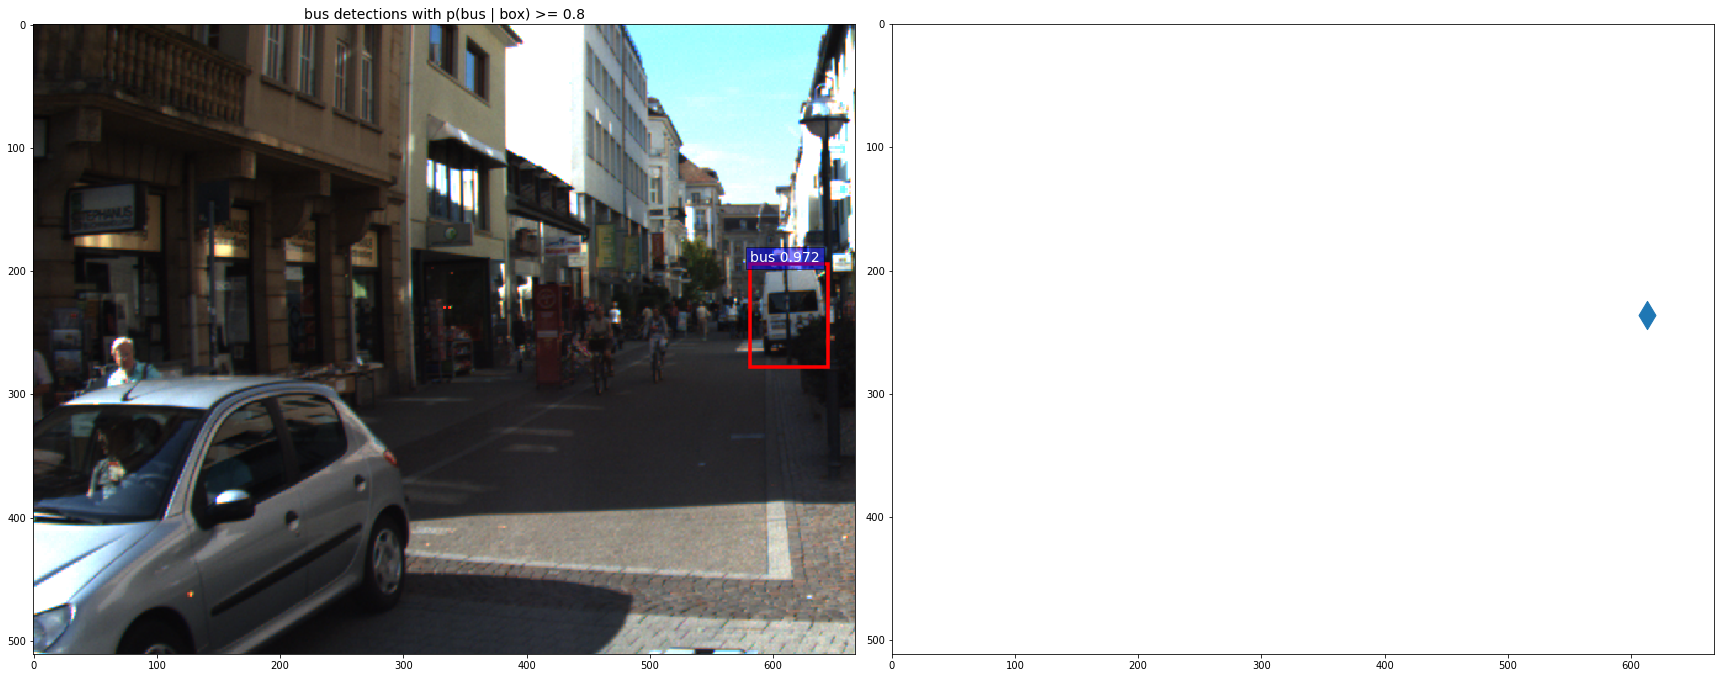

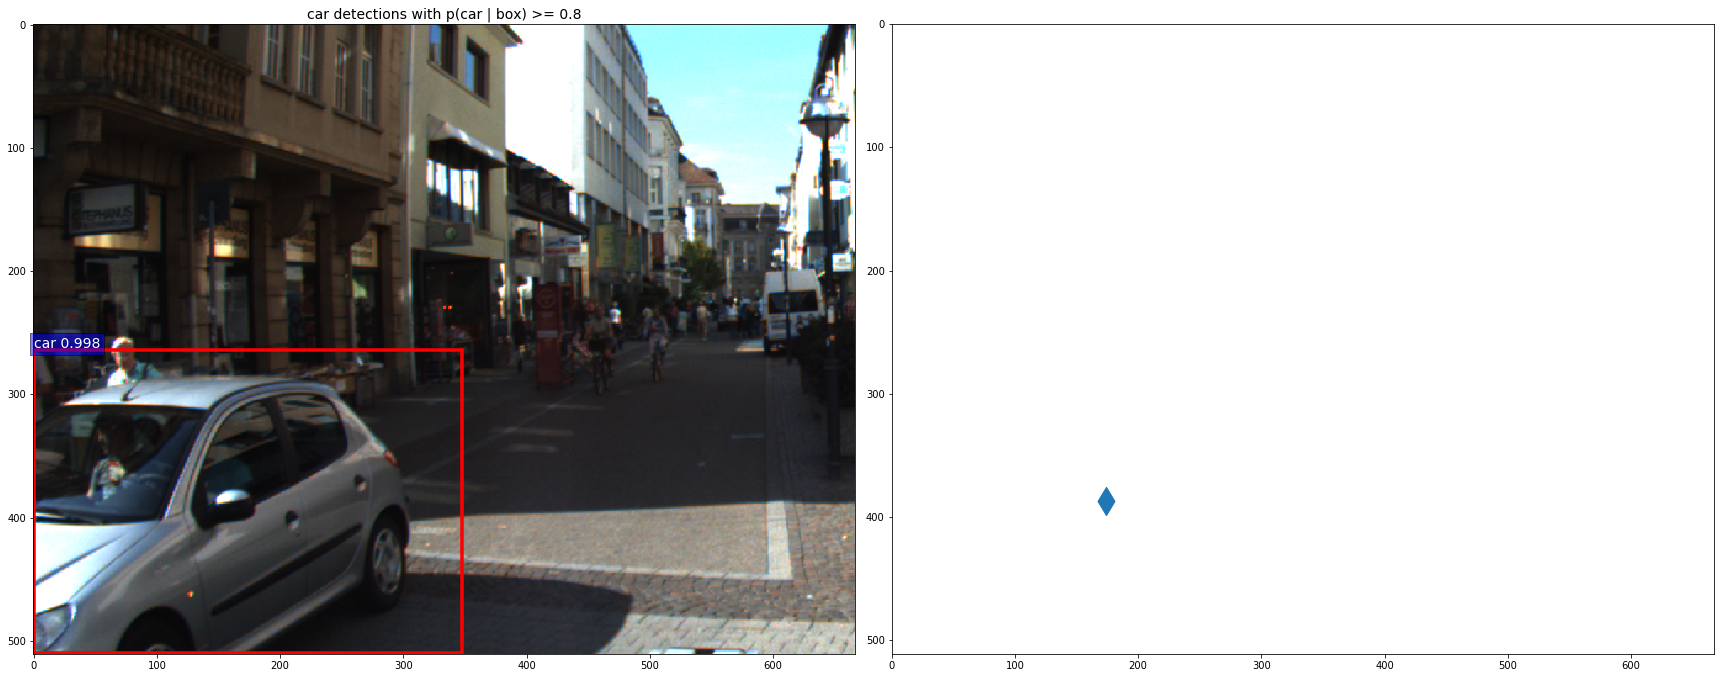

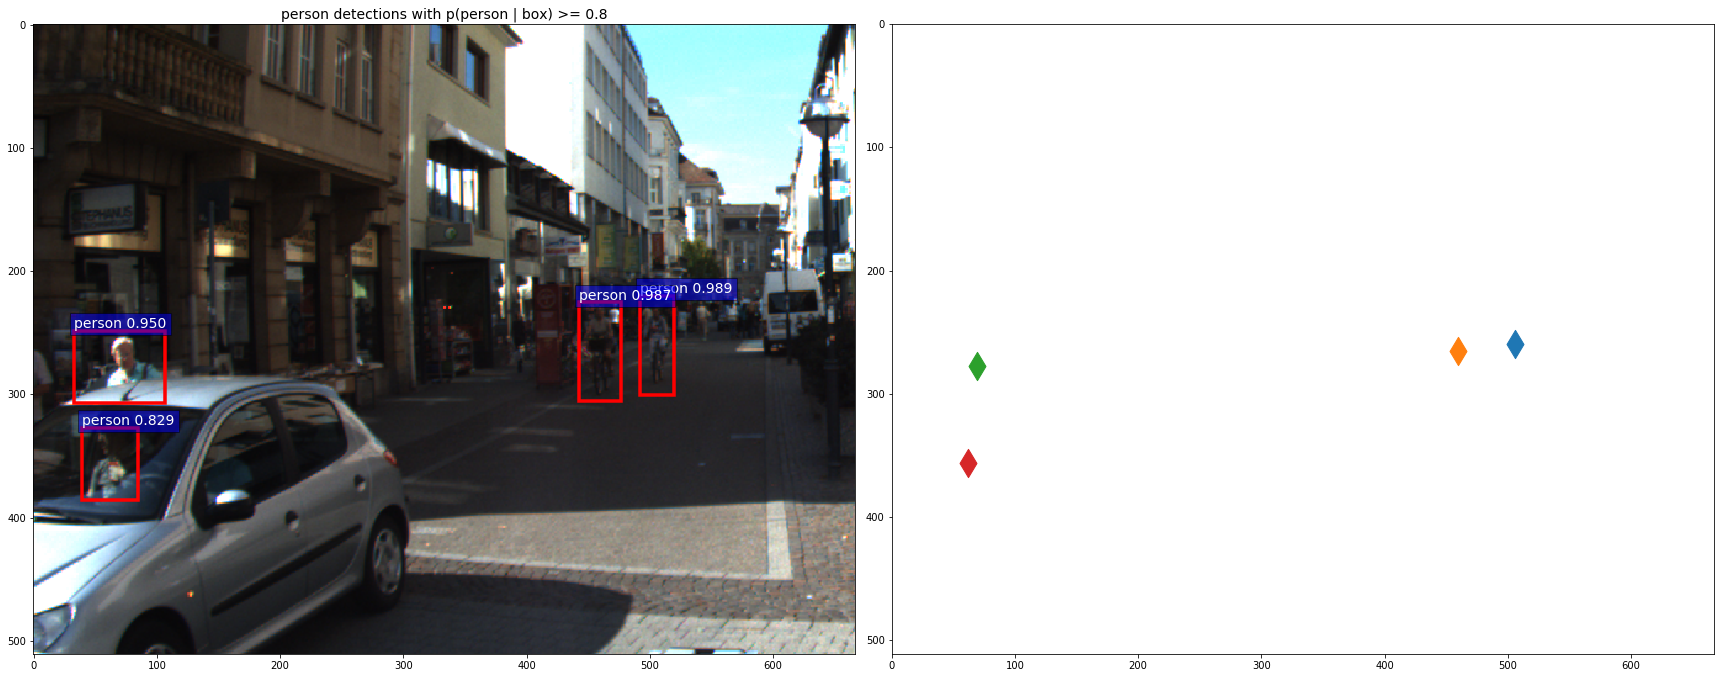

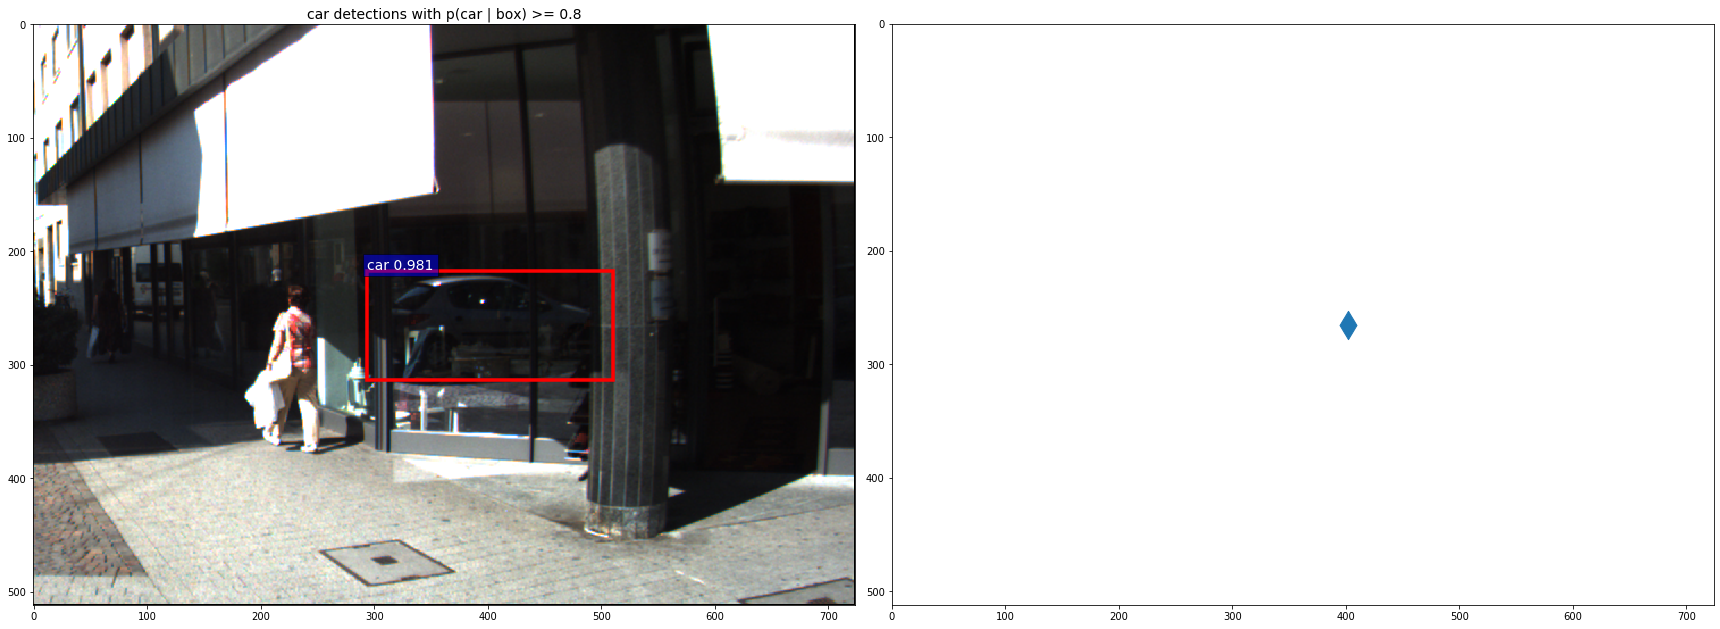

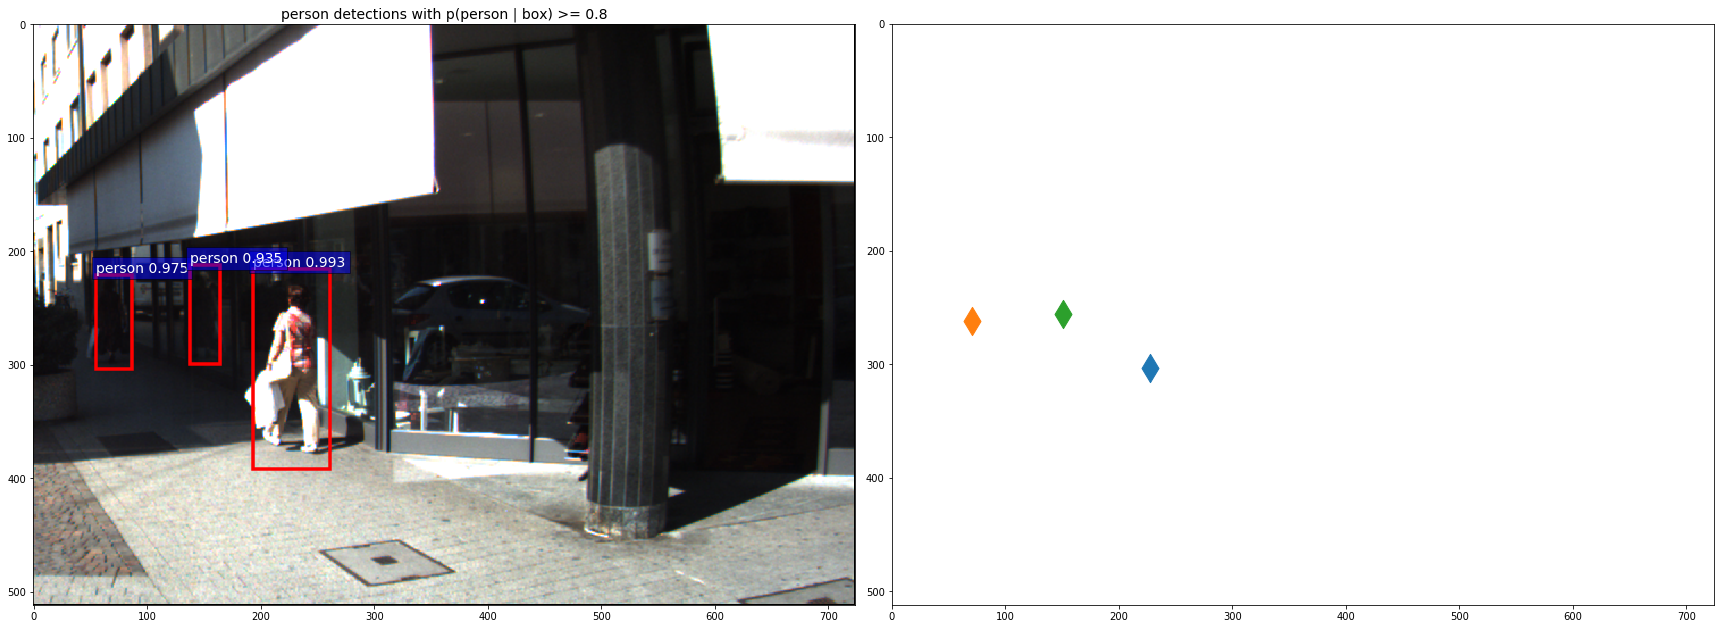

In [61]:
if True:
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    # model path
    saved_model = os.path.join('../output', demonet,
                              NETS[demonet][0] %(70000 if dataset == 'pascal_voc' else 110000))


    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    # load network
    if demonet == 'vgg16':
        net = vgg16()
    elif demonet == 'res101':
        net = resnetv1(num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(21,
                          tag='default', anchor_scales=[8, 16, 32])

    net.load_state_dict(torch.load(saved_model, map_location=lambda storage, loc: storage))

    net.eval()
    if not torch.cuda.is_available():
        net._device = 'cpu'
    net.to(net._device)

    print('Loaded network {:s}'.format(saved_model))

    start = datetime.datetime.now()
    im_names = ['0000000000_L.png', '0000000000_R.png']
    for im_name in im_names:
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('Demo for data/demo/{}'.format(im_name))
        demo(net, im_name)
    end = datetime.datetime.now()
    print (start, "[", end - start, "]", end)

    plt.show()

# Rotate plot
# https://stackoverflow.com/questions/12848581/is-there-a-way-to-rotate-a-matplotlib-plot-by-45-degrees
# resize the simplified image into (width/4, height/2)
# make slide show

In [ ]:
NETS[demonet][0]

In [ ]:
demonet = 'res101' # Network to use [vgg16 res101]
dataset = 'pascal_voc_0712' # Trained dataset [pascal_voc pascal_voc_0712]